In [1]:
# Imports
%matplotlib inline
import quandl
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import backtesters
reload(backtesters)
from backtesters import MABacktester, RSIBacktester, PanteraBacktester, \
    MACDBacktester, PortfolioBacktester, BuyIfUpBacktester, NewHighBacktester

In [6]:
# Get price data from Quandl
bitcoin = quandl.get("BCHAIN/MKPRU")
bitcoin = bitcoin.shift(-1) # data set has daily open, we want daily close
# Remove the 0's
bitcoin = bitcoin.loc['2011-01-01':] # bitcoin.loc['2010-08-17':]
bitcoin.columns = ['last']

In [61]:
# Pantera strategy is to buy when price breaks below 200 day MA and hold for 1 year
# This version is only long or short one trade at a time
pantera = PanteraBacktester(bitcoin['last'], ml = 200, hold = 365) 
print pantera
print pantera.results()

Pantera Backtest Strategy (ms=1, ml=200, hold=365, ema=False, start=2011-01-01, end=2018-07-09)
{'Strategy_pa': 41.42, 'Market_sharpe': 3.55, 'Sharpe': 1.49, 'Market_pa': 279.02, 'Trades_per_month': 0.11, 'Trades': 10, 'Years': 7.52, 'Market': 2241220.72, 'Strategy': 1253.55}


In [5]:
pantera_trades = pantera.trades()
print "Simple average return %.1f%%" % (pantera_trades['Return'].mean() * 100)
print "Geometric average return %.1f%%" % (((pantera_trades['Return']+1).cumprod()[-1]**(1.0/len(pantera_trades)) -1) *100)
pantera_trades

Simple average return 190.1%
Geometric average return 68.4%


,Type,Entry,Exit,Days,Return
Date,,,,,
2011-09-04,Long,8.467,10.593,365,0.251140
2013-07-04,Long,67.858,632.780,365,8.325001
2014-07-23,Long,601.180,287.300,365,-0.522107
2015-08-19,Long,233.290,576.030,365,1.469159
2018-02-05,Long,6838.817,6723.873,154,-0.016808


In [19]:
# Now look trade by trade every time it crosses under the 200 day MA
df = bitcoin.copy()
df['ms'] = np.round(df['last'].rolling(window=1).mean(), 8)
df['ml'] = np.round(df['last'].rolling(window=200).mean(), 8)
df['mdiff'] = df['ms'] - df['ml']
df['buy'] = np.where( (df['mdiff'] < 0) & (df['mdiff'].shift(1)>0), 1, 0)

In [24]:
trades = df[df['buy'] == 1]
trades

,last,ms,ml,mdiff,buy
Date,,,,,
2011-09-04,8.467000,8.467000,8.560967,-0.093967,1
2012-01-16,6.980000,6.980000,7.020437,-0.040437,1
2012-02-11,5.850000,5.850000,5.888786,-0.038786,1
2012-03-07,5.000000,5.000000,5.027730,-0.027730,1
2013-07-04,67.858440,67.858440,72.523528,-4.665088,1
2013-10-01,104.470000,104.470000,110.553473,-6.083473,1
2014-03-26,520.200000,520.200000,543.948950,-23.748950,1
2014-06-01,631.490000,631.490000,646.608650,-15.118650,1
2014-06-03,644.660000,644.660000,648.892600,-4.232600,1


In [65]:
compount_ret = 1

for buy_date, row in trades.iterrows():
    sell_date = buy_date + pd.DateOffset(days=365)
    try:
        sell_price = df['last'].loc[sell_date]
    except:
        sell_price = df['last'][-2]
    compount_ret *= sell_price / row['last']
    print buy_date,row['last'],sell_price,(sell_price / row['last'] - 1) * 100.0
    
print (compount_ret - 1) * 100 # 1,179% 12.79x
print (df['last'].iloc[-2] / df['last'].loc['2011-09-04'] - 1) * 100 # 79,312% 794x
#print compount_ret

2011-09-04 00:00:00 8.467 10.5934 25.113971890870435
2012-01-16 00:00:00 6.98 14.689 110.44412607449856
2012-02-11 00:00:00 5.85 24.1955 313.5982905982906
2012-03-07 00:00:00 5.0 42.98 759.6
2013-07-04 00:00:00 67.85844 632.78 832.5000692618339
2013-10-01 00:00:00 104.47 375.85 259.76835455154594
2014-03-26 00:00:00 520.2 248.63 -52.204921184159936
2014-06-01 00:00:00 631.49 224.83 -64.39690256377773
2014-06-03 00:00:00 644.66 225.54 -65.01411596810722
2014-06-09 00:00:00 649.89 228.01 -64.9156011017249
2014-07-23 00:00:00 601.18 287.3 -52.21065238364548
2014-08-01 00:00:00 591.59 280.69 -52.5532885951419
2014-08-04 00:00:00 580.21 282.69 -51.27798555695352
2014-08-10 00:00:00 578.97 265.85 -54.08224951206453
2015-08-19 00:00:00 233.29 576.03 146.91585580179174
2015-10-06 00:00:00 245.25 612.35 149.68399592252806
2018-02-05 00:00:00 6838.81666667 6723.8725 -1.6807610478900115
2018-03-10 00:00:00 8746.002 6723.8725 -23.120615568119007
2018-03-14 00:00:00 8151.53166667 6723.8725 -17.5139

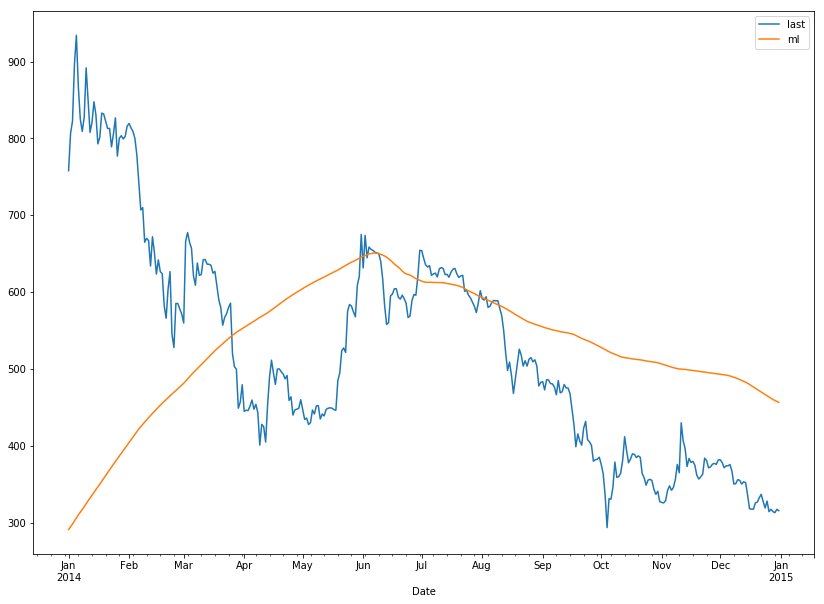

In [56]:
df[['last','ml']].loc['2014'].plot(figsize=(14,10))